This project focuses on predicting customer churn using a supervised machine learning approach. Churn refers to when a customer discontinues their use of a company’s services. Accurately identifying customers at risk of churning can help businesses take targeted actions to improve retention.

Using a dataset containing over 440,000 customer records, this project applies models such as logistic regression and decision trees, this project aims to identify key patterns that contribute to churn behavior. These insights can help businesses proactively target at-risk customers and design strategies to improve customer retention.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [3]:
churn_df = pd.read_csv('customer_churn_dataset-training-master.csv')
churn_df.head(3)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0


We begin by loading the customer churn dataset and displaying the first few rows. This helps us understand the structure and contents of the data before any processing.

In [4]:
churn_df.info()
churn_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [ ]:
# Drop rows with nulls
churn_df.dropna(inplace=True)

# Binary encoding for 'Gender'
churn_df['Gender'] = churn_df['Gender'].map({'Male': 0, 'Female': 1})

# One-hot encode 'Subscription Type' and 'Contract Length'
df = pd.get_dummies(churn_df, columns=['Subscription Types', 'Contract Lengths'], drop_first=True)

# Confirm no object columns remain
df.select_dtypes(include='object').columns

Index([], dtype='object')

We check for missing values and drop any rows containing nulls to ensure data quality. Next, we encode categorical variables: 'Gender' is binary encoded, while 'Subscription Type' and 'Contract Length' are one-hot encoded. This step is crucial because machine learning models require numerical input.

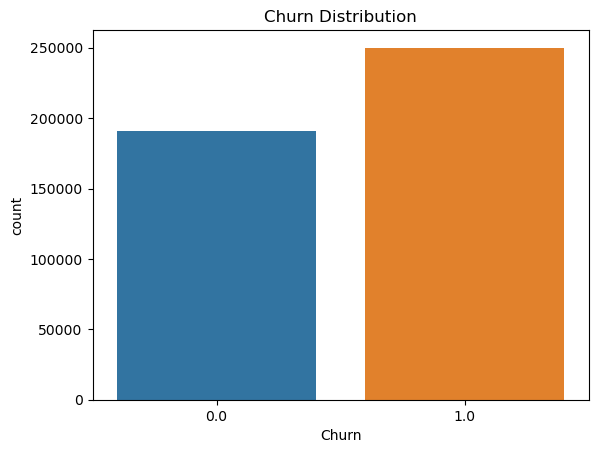

In [6]:
sns.countplot(x='Churn', data=churn_df)
plt.title('Churn Distribution')
plt.show()

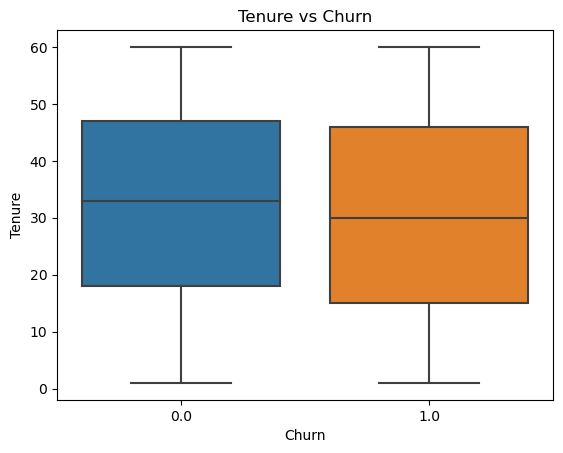

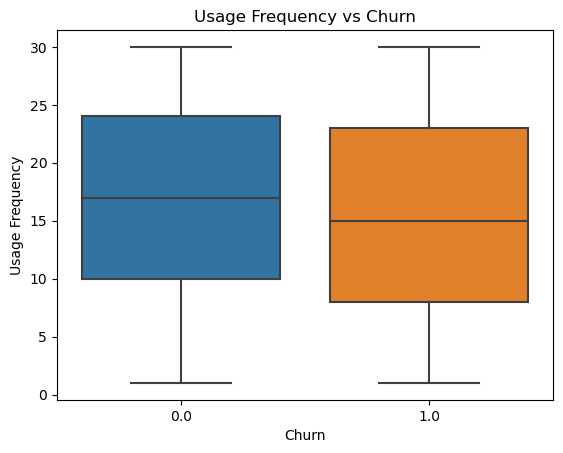

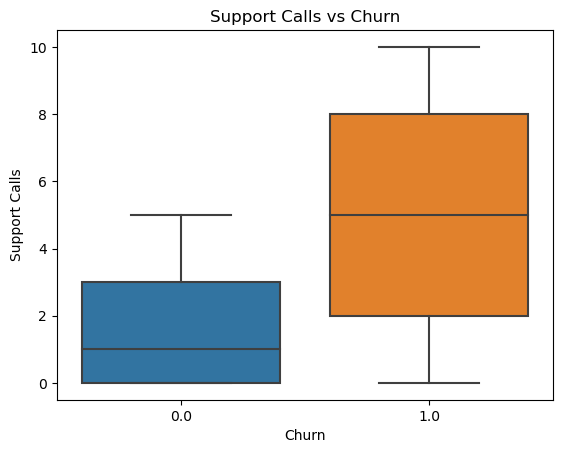

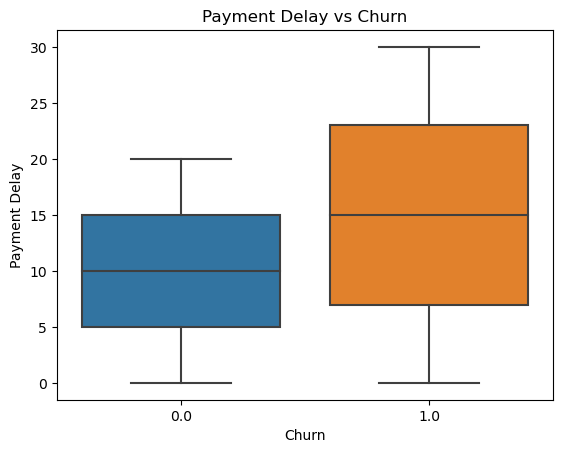

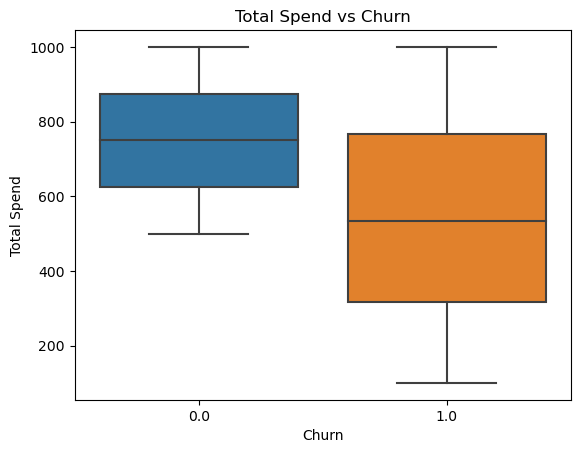

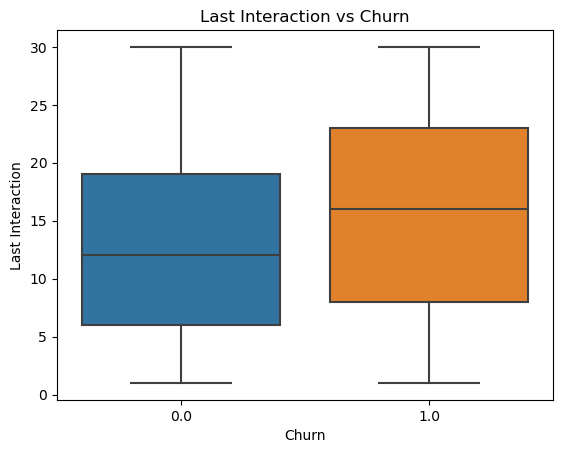

In [7]:
features = ['Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
for col in features:
    sns.boxplot(x='Churn', y=col, data=churn_df)
    plt.title(f'{col} vs Churn')
    plt.show()

We visualize the distribution of the target variable ('Churn') and use boxplots to explore how key features differ between churned and non-churned customers. This helps identify potential predictors and understand feature relationships.

In [8]:
# Separate features and target
X = df.drop(['CustomerID', 'Churn'], axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a small training set for quick testing
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=0.1, random_state=42, stratify=y_train
)

We split the data into training and test sets to evaluate model performance on unseen data. Additionally, we create a smaller training sample (10% of the training set) for faster hyperparameter tuning during grid search.

In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Pruned decision tree
tree = DecisionTreeClassifier(max_depth=6, min_samples_split=20, min_samples_leaf=10, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [10]:
from sklearn.metrics import accuracy_score

y_pred_log = log_reg.predict(X_test_scaled)
y_pred_tree = tree.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_log))
print("Decision Tree:")
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     38063
         1.0       0.93      0.89      0.91     50104

    accuracy                           0.90     88167
   macro avg       0.89      0.90      0.90     88167
weighted avg       0.90      0.90      0.90     88167

Decision Tree:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     38063
         1.0       1.00      0.96      0.98     50104

    accuracy                           0.98     88167
   macro avg       0.98      0.98      0.98     88167
weighted avg       0.98      0.98      0.98     88167



We train a baseline logistic regression model (with feature scaling) and a pruned decision tree using manually selected hyperparameters. These models provide reference points for evaluating more complex, tuned models later.

In [11]:
# Define pipelines
pipe_lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])
pipe_tree = Pipeline([('clf', DecisionTreeClassifier(random_state=42))])
pipe_svm = Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True))])
pipe_knn = Pipeline([('scaler', MinMaxScaler()), ('clf', KNeighborsClassifier())])

# Parameter grids
param_lr = {'clf__C': [0.01, 0.1, 1, 10], 'clf__solver': ['liblinear', 'lbfgs']}
param_tree = {'clf__max_depth': [4, 6, 8], 'clf__min_samples_split': [10, 20, 40], 'clf__min_samples_leaf': [5, 10, 20]}
param_svm = {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}
param_knn = {'clf__n_neighbors': [3, 5, 7], 'clf__weights': ['uniform', 'distance']}

# Grid search
grid_lr = GridSearchCV(pipe_lr, param_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_tree = GridSearchCV(pipe_tree, param_tree, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm = GridSearchCV(pipe_svm, param_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_knn = GridSearchCV(pipe_knn, param_knn, cv=3, scoring='accuracy', n_jobs=-1)

# Fit models
grid_lr.fit(X_train_small, y_train_small)
grid_tree.fit(X_train_small, y_train_small)
grid_svm.fit(X_train_small, y_train_small)
grid_knn.fit(X_train_small, y_train_small)

/Users/krithikandury/miniconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [3, 5, 7],
                         'clf__weights': ['uniform', 'distance']},
             scoring='accuracy')

We set up pipelines for Logistic Regression, SVM, KNN, and Decision Tree models. Each pipeline includes necessary preprocessing steps. We then use GridSearchCV to find the best hyperparameters for each model, using the small training sample for efficiency.

In [12]:
models = {
    "Logistic Regression": grid_lr,
    "SVM": grid_svm,
    "KNN": grid_knn,
    "Decision Tree": grid_tree
}

for name, model in models.items():
    print(f"--- {name} ---")
    y_pred = model.predict(X_test)
    print("Best Parameters:", model.best_params_)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print()

--- Logistic Regression ---
Best Parameters: {'clf__C': 0.01, 'clf__solver': 'liblinear'}
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88     38063
         1.0       0.93      0.88      0.91     50104

    accuracy                           0.90     88167
   macro avg       0.89      0.90      0.90     88167
weighted avg       0.90      0.90      0.90     88167

[[34859  3204]
 [ 5926 44178]]

--- SVM ---
Best Parameters: {'clf__C': 10, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     38063
         1.0       0.99      0.97      0.98     50104

    accuracy                           0.98     88167
   macro avg       0.98      0.98      0.98     88167
weighted avg       0.98      0.98      0.98     88167

[[37805   258]
 [ 1698 48406]]

--- KNN ---
Best Parameters: {'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
              precision    recall  f1-score   

We compare all tuned models on the test set, printing the best hyperparameters and classification metrics for each. This allows us to see which model performs best and why.

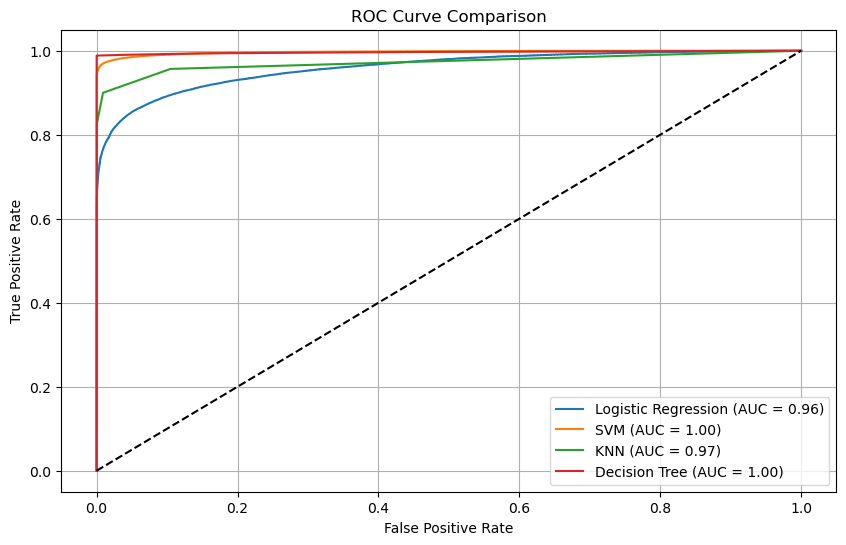

In [ ]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparisons')
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.legend()
plt.grid(True)
plt.show()

We plot ROC curves for all models to visualize their ability to distinguish between churners and non-churners at various thresholds. The Area Under the Curve (AUC) provides a single metric to compare model performance: the closer to 1, the better.

The ROC curve comparison shows how well each model distinguishes between customers who will churn and those who will not. The SVM and Decision Tree models both achieved an AUC of 1.00, which indicates perfect classification performance on the evaluation set. While this may seem ideal, such perfect scores often suggest overfitting—meaning the model may be memorizing the training data rather than generalizing well to unseen data. In contrast, the K-Nearest Neighbors model achieved an AUC of 0.97 and Logistic Regression scored 0.96, both of which are excellent but more realistic indicators of strong model performance.

Logistic Regression’s slightly lower AUC suggests it is more conservative but likely generalizes better across different data. KNN also performs very well, particularly due to its ability to recognize local patterns when the features are scaled appropriately. Overall, while all four models appear strong based on AUC, the perfect scores from SVM and Decision Tree warrant caution and may benefit from further validation using cross-validation or additional holdout data. From a reliability standpoint, Logistic Regression and KNN may offer a better balance between accuracy and generalizability.

Conclusion:
This project applied multiple machine learning models to predict customer churn, including Logistic Regression, Decision Tree, SVM, and KNN. Using pipelines and GridSearchCV, each model was optimized and evaluated. While SVM and Decision Tree achieved perfect AUC scores, this likely indicates overfitting. Logistic Regression and KNN offered more realistic, generalizable performance with AUCs of 0.96 and 0.97. Overall, Logistic Regression provided the best balance of accuracy, interpretability, and reliability, making it the most suitable model for deployment.